In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pickle
import os

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import xgboost as xgb
from xgboost import plot_importance

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

In [3]:
model_path_name = "dummy_features"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"

In [4]:
if not os.path.exists(DIRECTORY_PATH):
    os.makedirs(DIRECTORY_PATH)
with open(MODEL_INFO_FILEPATH, "w") as text_file:
    print(f"##### MODEL INFO #####", file=text_file)
    print(f"Using features (including categorical variables) that account for previous results from entire game (not just previous play). Don't start collecting till at least 10 plays", file=text_file)

In [5]:
dataset = pd.read_pickle("data/dummy_dataset.pkl")

In [6]:
print(dataset.shape[0]*.80)
print(dataset.shape[0]*.10)

15867.2
1983.4


In [7]:
train_index_stop = 15970 # this is the first index of a new pitcher
val_index_stop = 17987 # make sure no overlapping plays

training_set = dataset.iloc[0:train_index_stop, :]
validation_set = dataset.iloc[train_index_stop:val_index_stop, :]
test_set = dataset.iloc[val_index_stop:,]

In [8]:
train_X = training_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
train_y = training_set['RUNPASS']

val_X = validation_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
val_y = validation_set['RUNPASS']

test_X = test_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
test_y = test_set['RUNPASS']

In [9]:
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Input features: {train_X.columns.values}", file=text_file)

In [10]:
# have to convert to numerics for XGBoost 
mapping = {'R' : 0,
           'P': 1
           }

In [11]:
train_y = train_y.map(mapping)
val_y = val_y.map(mapping)
test_y = test_y.map(mapping)

In [12]:
train_y.value_counts(normalize=True)

RUNPASS
1    0.611334
0    0.388666
Name: proportion, dtype: float64

In [13]:
bparams = {'max_depth': 6,
 'learning_rate': 0.23414476853402916,
 'n_estimators': 800,
 'subsample': 0.7000000000000001,
 'min_child_weight': 4}

clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                        objective='binary:logistic', eval_metric=['error','logloss', 'auc'], **bparams)
clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

[0]	validation_0-error:0.35697	validation_0-logloss:0.61963	validation_0-auc:0.75139
[1]	validation_0-error:0.32524	validation_0-logloss:0.59451	validation_0-auc:0.76359
[2]	validation_0-error:0.31433	validation_0-logloss:0.57773	validation_0-auc:0.76807
[3]	validation_0-error:0.30243	validation_0-logloss:0.56567	validation_0-auc:0.77162
[4]	validation_0-error:0.29450	validation_0-logloss:0.55622	validation_0-auc:0.77626
[5]	validation_0-error:0.28756	validation_0-logloss:0.54915	validation_0-auc:0.77905
[6]	validation_0-error:0.29003	validation_0-logloss:0.54564	validation_0-auc:0.78016
[7]	validation_0-error:0.28161	validation_0-logloss:0.54194	validation_0-auc:0.78204
[8]	validation_0-error:0.27962	validation_0-logloss:0.53904	validation_0-auc:0.78296
[9]	validation_0-error:0.28161	validation_0-logloss:0.53760	validation_0-auc:0.78354
[10]	validation_0-error:0.28557	validation_0-logloss:0.53464	validation_0-auc:0.78597
[11]	validation_0-error:0.28656	validation_0-logloss:0.53489	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric=['error', 'logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.23414476853402916, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [14]:
clf.evals_result()['validation_0']['error'][clf.best_iteration]

0.27863163113534956

In [15]:
# clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
#                                         objective='objective=multi:softmax', eval_metric=['merror','mlogloss'])
# clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

In [16]:
def objective(trial, train_X, train_y, val_X, val_y, train_weights=None, val_weights=None):
    param = {
             "max_depth": trial.suggest_int('max_depth', 2, 20,step=1),
              "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
              "n_estimators": trial.suggest_int('n_estimators', 50, 2950,step=100),
              "subsample" : trial.suggest_float('subsample', 0.1, 1, step=0.1),
              "min_child_weight" : trial.suggest_int('min_child_weight', 1, 10, step=1), 
              "colsample_bytree" : trial.suggest_float('subsample', 0.1, 1, step=0.1),
            }
    clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                        objective='binary:logistic', eval_metric=['error','logloss', 'auc'], **param)
    clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=0)  

    best_error = clf.evals_result()['validation_0']['error'][clf.best_iteration]
    return best_error


In [17]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda x : objective(x, train_X, train_y, val_X, val_y), n_trials=30)
print(study.best_trial)

[I 2024-05-06 02:51:17,151] A new study created in memory with name: no-name-80cd5e17-bf2b-4b4c-a550-500821478191
[I 2024-05-06 02:51:18,328] Trial 0 finished with value: 0.27565691621219635 and parameters: {'max_depth': 11, 'learning_rate': 0.1905357528161239, 'n_estimators': 1850, 'subsample': 0.9, 'min_child_weight': 7}. Best is trial 0 with value: 0.27565691621219635.
[I 2024-05-06 02:51:19,975] Trial 1 finished with value: 0.2845810609816559 and parameters: {'max_depth': 13, 'learning_rate': 0.040283547867350764, 'n_estimators': 2350, 'subsample': 0.9, 'min_child_weight': 2}. Best is trial 0 with value: 0.27565691621219635.
[I 2024-05-06 02:51:21,941] Trial 2 finished with value: 0.31036192364898363 and parameters: {'max_depth': 16, 'learning_rate': 0.020443630067370405, 'n_estimators': 2350, 'subsample': 0.2, 'min_child_weight': 2}. Best is trial 0 with value: 0.27565691621219635.
[I 2024-05-06 02:51:22,930] Trial 3 finished with value: 0.2751611303916708 and parameters: {'max_de

FrozenTrial(number=12, state=TrialState.COMPLETE, values=[0.27317798710956864], datetime_start=datetime.datetime(2024, 5, 6, 2, 51, 36, 586600), datetime_complete=datetime.datetime(2024, 5, 6, 2, 51, 37, 358685), params={'max_depth': 8, 'learning_rate': 0.1279444549281632, 'n_estimators': 2850, 'subsample': 0.7000000000000001, 'min_child_weight': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=20, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=2950, log=False, low=50, step=100), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=12, value=None)


In [18]:
print(f"Best Params = {study.best_params}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Params = {study.best_params}", file=text_file)

Best Params = {'max_depth': 8, 'learning_rate': 0.1279444549281632, 'n_estimators': 2850, 'subsample': 0.7000000000000001, 'min_child_weight': 10}


In [19]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                        objective='binary:logistic', eval_metric=['error','logloss', 'auc'], **study.best_params)
clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

[0]	validation_0-error:0.37234	validation_0-logloss:0.63448	validation_0-auc:0.76450
[1]	validation_0-error:0.36143	validation_0-logloss:0.61513	validation_0-auc:0.77080
[2]	validation_0-error:0.33466	validation_0-logloss:0.60027	validation_0-auc:0.77036
[3]	validation_0-error:0.31978	validation_0-logloss:0.58715	validation_0-auc:0.77385
[4]	validation_0-error:0.30491	validation_0-logloss:0.57584	validation_0-auc:0.77786
[5]	validation_0-error:0.30293	validation_0-logloss:0.56778	validation_0-auc:0.77816
[6]	validation_0-error:0.29945	validation_0-logloss:0.56184	validation_0-auc:0.77761
[7]	validation_0-error:0.29797	validation_0-logloss:0.55724	validation_0-auc:0.77669
[8]	validation_0-error:0.29747	validation_0-logloss:0.55387	validation_0-auc:0.77577
[9]	validation_0-error:0.29648	validation_0-logloss:0.54789	validation_0-auc:0.78012
[10]	validation_0-error:0.29549	validation_0-logloss:0.54451	validation_0-auc:0.78126
[11]	validation_0-error:0.29053	validation_0-logloss:0.54174	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric=['error', 'logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1279444549281632, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2850, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
pickle.dump(clf, open(f"{DIRECTORY_PATH}/xgb_model.pkl", "wb"))

In [21]:
best_val_merror = clf.evals_result()['validation_0']['error'][clf.best_iteration]
best_val_mlogloss = clf.evals_result()['validation_0']['logloss'][clf.best_iteration]
best_val_auc = clf.evals_result()['validation_0']['auc'][clf.best_iteration]

print(f"Best Val error = {best_val_merror}")
print(f"Best Val logloss = {best_val_mlogloss}")
print(f"Best Val AUC = {best_val_auc}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Val error = {best_val_merror}", file=text_file)
    print(f"Best Val logloss = {best_val_mlogloss}", file=text_file)
    print(f"Best Val AUC = {best_val_auc}", file=text_file)

Best Val error = 0.2721864154685176
Best Val logloss = 0.5249524940087852
Best Val AUC = 0.7943957819274143


In [81]:
#y_pred_probs = clf.predict_proba(val_X)

In [22]:
# y_pred_probs = clf.predict_proba(val_X)
y_pred = clf.predict(val_X)

print('\n------------------ Confusion Matrix -----------------\n')
cmatrix = confusion_matrix(val_y, y_pred)
print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print('\n------------------ Confusion Matrix for Full Model -----------------\n', file=text_file)
    print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)


------------------ Confusion Matrix -----------------

     R     P
R  433   318
P  231  1035


In [23]:
# row i represents all true class i
# recall = (np.diagonal(confusion_matrix)/np.sum(confusion_matrix,axis=1)).round(3)
print(classification_report(val_y, y_pred, target_names=list(mapping.keys())))

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(classification_report(val_y, y_pred, target_names=list(mapping.keys())), file=text_file)

              precision    recall  f1-score   support

           R       0.65      0.58      0.61       751
           P       0.76      0.82      0.79      1266

    accuracy                           0.73      2017
   macro avg       0.71      0.70      0.70      2017
weighted avg       0.72      0.73      0.72      2017



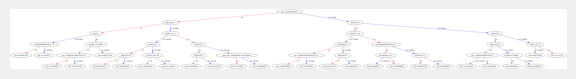

In [55]:
xgb.plot_tree(clf)
plt.show()

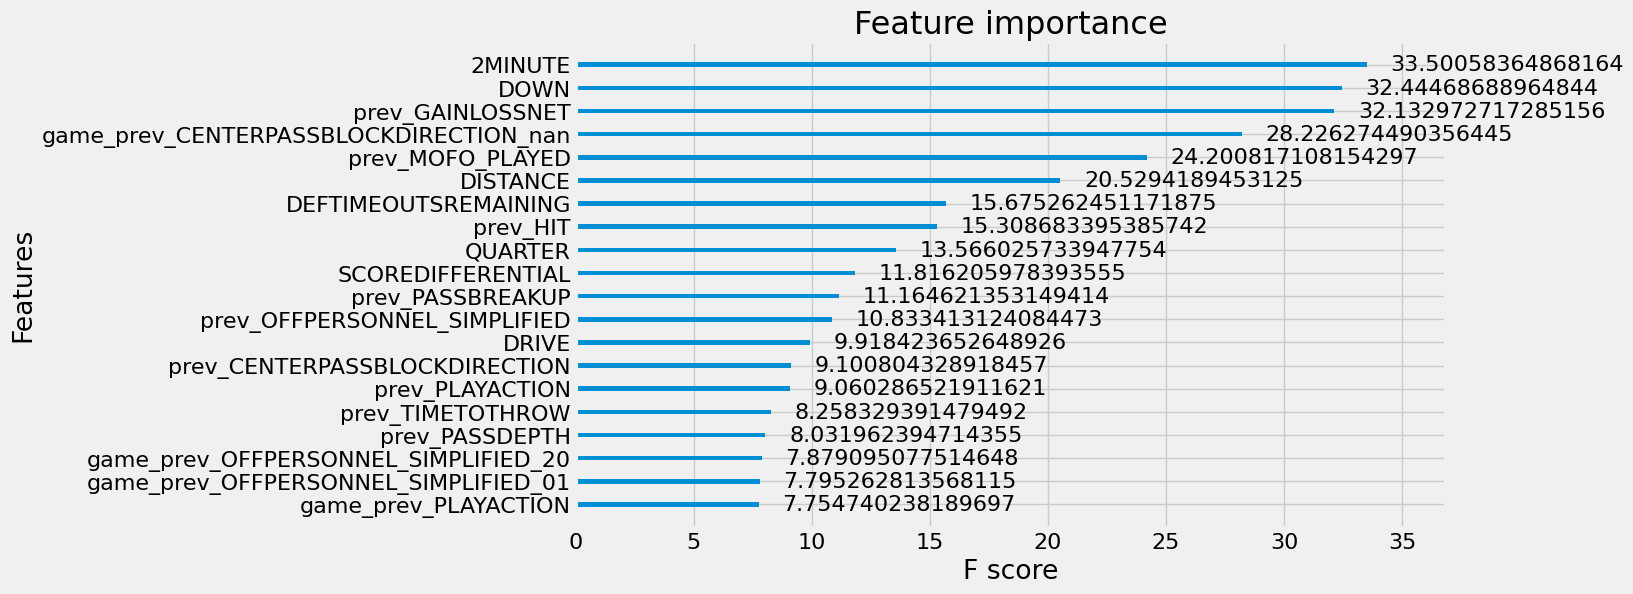

In [24]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax1 = plt.subplots(1,1, figsize=(10,6))
plot_importance(clf, importance_type='gain', max_num_features=20, ax=ax1)
plt.savefig(f"{DIRECTORY_PATH}/feature_importance.png", bbox_inches = 'tight')
plt.show()

In [25]:
from sklearn.metrics import accuracy_score
y_test_pred = clf.predict(test_X)

In [28]:
test_accuracy = accuracy_score(test_y, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Test Accuracy = {test_accuracy}", file=text_file)

Test Accuracy: 0.7195452084461289


In [27]:

print('\n------------------ TEST DATA Confusion Matrix -----------------\n')
test_cmatrix = confusion_matrix(test_y, y_test_pred)
print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print('\n------------------ TEST DATA Confusion Matrix for Full Model -----------------\n', file=text_file)
    print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)
print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())))
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())), file=text_file)



------------------ TEST DATA Confusion Matrix -----------------

     R    P
R  428  293
P  225  901
              precision    recall  f1-score   support

           R       0.66      0.59      0.62       721
           P       0.75      0.80      0.78      1126

    accuracy                           0.72      1847
   macro avg       0.71      0.70      0.70      1847
weighted avg       0.72      0.72      0.72      1847

